In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from matplotlib import rc # 폰트
# 유니코드 폰트 설정
rc('font', family='AppleGothic')
# 마이너스 기호 표시 설정
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
data = pd.read_csv('y10_22_month.csv')
data

,일시,지점,평균기온,최고기온,최저기온(°C),평균상대습도,최소상대습도
0,2010-01-01,108,-4.5,8.4,-15.3,65,26
1,2010-02-01,108,1.4,17.9,-10.8,59,14
2,2010-03-01,108,4.3,14.2,-4.0,59,13
3,2010-04-01,108,9.5,20.7,1.1,54,12
4,2010-05-01,108,17.2,28.6,5.8,62,21
...,...,...,...,...,...,...,...
151,2022-08-01,108,25.7,32.9,16.1,80,39
152,2022-09-01,108,22.4,32.5,12.3,68,29
153,2022-10-01,108,14.6,27.6,4.4,69,25
154,2022-11-01,108,10.0,22.1,-8.1,65,23


In [4]:
# 일시, 평균기온, 평균상대습도 데이터만 추출
data_dta = data.loc[:, ["일시", "평균기온", "평균상대습도"]]
data_dta

,일시,평균기온,평균상대습도
0,2010-01-01,-4.5,65
1,2010-02-01,1.4,59
2,2010-03-01,4.3,59
3,2010-04-01,9.5,54
4,2010-05-01,17.2,62
...,...,...,...
151,2022-08-01,25.7,80
152,2022-09-01,22.4,68
153,2022-10-01,14.6,69
154,2022-11-01,10.0,65


In [5]:
# 컬럼명 변경
data_dta.columns = ['Date', 'MeanTemp', 'ARH']
data_dta

,Date,MeanTemp,ARH
0,2010-01-01,-4.5,65
1,2010-02-01,1.4,59
2,2010-03-01,4.3,59
3,2010-04-01,9.5,54
4,2010-05-01,17.2,62
...,...,...,...
151,2022-08-01,25.7,80
152,2022-09-01,22.4,68
153,2022-10-01,14.6,69
154,2022-11-01,10.0,65


In [6]:
# 의약품가격데이터 불러오기(A05, T61, T78) + 데이터 합치기
A05 = pd.read_excel('A05 2010-2022.xlsx')
T61 = pd.read_excel('T61 2010-2022.xlsx')
T78 = pd.read_excel('T78 2010-2022.xlsx')

# 'Category' 컬럼의 값을 'yyyy-mm-01' 형식으로 변환
A05['Category'] = pd.to_datetime(A05['Category'], format='%Y%m').dt.strftime('%Y-%m-%d')
T61['Category'] = pd.to_datetime(T61['Category'], format='%Y%m').dt.strftime('%Y-%m-%d')
T78['Category'] = pd.to_datetime(T78['Category'], format='%Y%m').dt.strftime('%Y-%m-%d')

AU = pd.merge(A05, T61, on='Category')
AU = pd.merge(AU, T78, on='Category')
AU

,Category,사용금액_x,사용금액_y,사용금액
0,2010-01-01,56398887,3121279,77640736
1,2010-02-01,54440020,1188833,75477647
2,2010-03-01,57782217,1481292,85038128
3,2010-04-01,55537175,12501228,88930460
4,2010-05-01,49199325,2459549,101073739
...,...,...,...,...
151,2022-08-01,42918408,761678,495302437
152,2022-09-01,27768210,777352,465947809
153,2022-10-01,23261359,3207258,416668623
154,2022-11-01,29610163,3638009,421163846


In [7]:
# 컬럼명 변경
AU.columns = ['Date', 'A05', 'T61', 'T78']
AU

,Date,A05,T61,T78
0,2010-01-01,56398887,3121279,77640736
1,2010-02-01,54440020,1188833,75477647
2,2010-03-01,57782217,1481292,85038128
3,2010-04-01,55537175,12501228,88930460
4,2010-05-01,49199325,2459549,101073739
...,...,...,...,...
151,2022-08-01,42918408,761678,495302437
152,2022-09-01,27768210,777352,465947809
153,2022-10-01,23261359,3207258,416668623
154,2022-11-01,29610163,3638009,421163846


In [8]:
# 날짜, 평균온도, 평균상대습도, 의약품가격(3개) 데이터 합치기
f_data = pd.merge(data_dta, AU, on='Date')
f_data

,Date,MeanTemp,ARH,A05,T61,T78
0,2010-01-01,-4.5,65,56398887,3121279,77640736
1,2010-02-01,1.4,59,54440020,1188833,75477647
2,2010-03-01,4.3,59,57782217,1481292,85038128
3,2010-04-01,9.5,54,55537175,12501228,88930460
4,2010-05-01,17.2,62,49199325,2459549,101073739
...,...,...,...,...,...,...
151,2022-08-01,25.7,80,42918408,761678,495302437
152,2022-09-01,22.4,68,27768210,777352,465947809
153,2022-10-01,14.6,69,23261359,3207258,416668623
154,2022-11-01,10.0,65,29610163,3638009,421163846


In [8]:
# 일시, 온도, 습도 상관분석
corr_dta = data_dta.corr()
corr_dta

,MeanTemp,ARH
MeanTemp,1.000000,0.668085
ARH,0.668085,1.000000


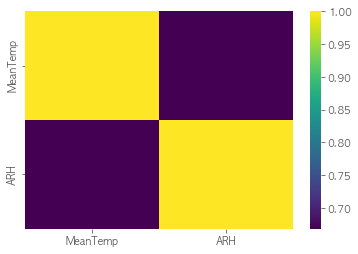

In [9]:
sns.heatmap(corr_dta, cmap = 'viridis')
plt.show()

In [10]:
# 날짜, 평균온도, 평균상대습도, 의약품가격(3개) 데이터 상관분석
corr_f_data = f_data.corr()
corr_f_data

,MeanTemp,ARH,A05,T61,T78
MeanTemp,1.000000,0.668085,0.291074,-0.229185,0.209379
ARH,0.668085,1.000000,0.331933,-0.164565,0.275369
A05,0.291074,0.331933,1.000000,-0.121720,-0.523146
T61,-0.229185,-0.164565,-0.121720,1.000000,-0.080207
T78,0.209379,0.275369,-0.523146,-0.080207,1.000000


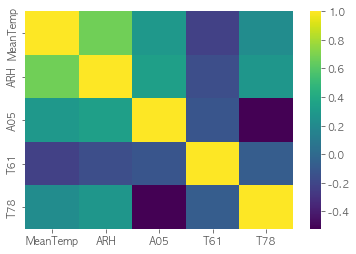

In [11]:
sns.heatmap(corr_f_data, cmap = 'viridis')
plt.show()

## 온도, 습도, 의약품(3) 다변량 변수 예측

In [12]:
features_considered = ['MeanTemp', 'ARH', 'A05', 'T61', 'T78']
features = f_data[features_considered]
features.index = f_data['Date']
features

,MeanTemp,ARH,A05,T61,T78
Date,,,,,
2010-01-01,-4.5,65,56398887,3121279,77640736
2010-02-01,1.4,59,54440020,1188833,75477647
2010-03-01,4.3,59,57782217,1481292,85038128
2010-04-01,9.5,54,55537175,12501228,88930460
2010-05-01,17.2,62,49199325,2459549,101073739
...,...,...,...,...,...
2022-08-01,25.7,80,42918408,761678,495302437
2022-09-01,22.4,68,27768210,777352,465947809
2022-10-01,14.6,69,23261359,3207258,416668623


<AxesSubplot:xlabel='Date'>

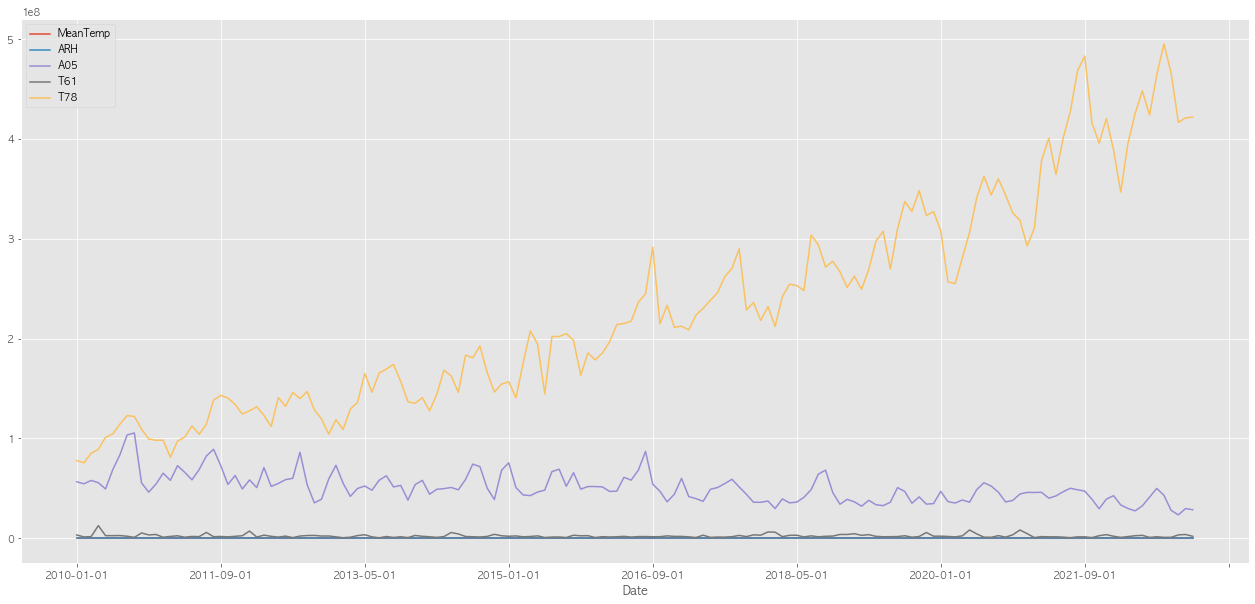

In [17]:
features.plot(figsize = (22,10))

In [22]:
# 정상성

adfuller_test = adfuller(features['MeanTemp'], autolag= "AIC")
print("=====MeanTemp=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['ARH'], autolag= "AIC")
print("=====ARH=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['A05'], autolag= "AIC")
print("=====A05=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['T61'], autolag= "AIC")
print("=====T61=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['T78'], autolag= "AIC")
print("=====T78=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))


=====MeanTemp=====
ADF test statistic: -2.6187684723145614
p-value: 0.08917991618690307

=====ARH=====
ADF test statistic: -1.3167980206410497
p-value: 0.6214525896030616

=====A05=====
ADF test statistic: -1.2210271861471598
p-value: 0.6644855775909438

=====T61=====
ADF test statistic: -8.540380684800862
p-value: 9.819674181421347e-14

=====T78=====
ADF test statistic: 1.3186572965964811
p-value: 0.9967113833985707


In [23]:
# 차분
features_diff = features.diff().dropna()

In [24]:
# 차분 취하고 다시 정상성 확인

adfuller_test = adfuller(features['MeanTemp'], autolag= "AIC")
print("=====MeanTemp=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['ARH'], autolag= "AIC")
print("=====ARH=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['A05'], autolag= "AIC")
print("=====A05=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['T61'], autolag= "AIC")
print("=====T61=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features['T78'], autolag= "AIC")
print("=====T78=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))


=====MeanTemp=====
ADF test statistic: -2.6187684723145614
p-value: 0.08917991618690307

=====ARH=====
ADF test statistic: -1.3167980206410497
p-value: 0.6214525896030616

=====A05=====
ADF test statistic: -1.2210271861471598
p-value: 0.6644855775909438

=====T61=====
ADF test statistic: -8.540380684800862
p-value: 9.819674181421347e-14

=====T78=====
ADF test statistic: 1.3186572965964811
p-value: 0.9967113833985707


## 모델링

In [25]:
# 마지막 5년(18-22)은 test, 나머지 8년(10-17)은 train
train = features_diff.iloc[:-24,:]
test = features_diff.iloc[-24:,:]

In [26]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

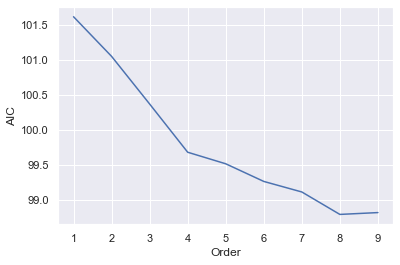

In [27]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [28]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Aug, 2023
Time:                     14:17:28
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    103.481
Nobs:                     123.000    HQIC:                   100.698
Log likelihood:          -6743.50    FPE:                9.19097e+42
AIC:                      98.7944    Det(Omega_mle):     2.18106e+42
--------------------------------------------------------------------
Results for equation MeanTemp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.200637         0.190159           -1.055           0.291
L1.MeanTemp        -0.324120         0.096896           -3.345           0.001
L1.ARH              0.029712         0.038014            0.782   

## Forcasting / 예측하기

In [32]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=24), index = test.index, columns= ['MeanTemp_1d', 'ARH_1d',  'A05_1d', 'T61_1d', 'T78_1d'])
forecast

,MeanTemp_1d,ARH_1d,A05_1d,T61_1d,T78_1d
Date,,,,,
2021-01-01,-0.543724,6.142163,5.135410e+06,-3.035149e+06,-1.234812e+07
2021-02-01,2.894857,-3.122291,-1.201720e+06,-1.127463e+06,2.981301e+07
2021-03-01,5.686317,-0.067039,-1.482816e+07,-4.645494e+05,-1.313955e+07
2021-04-01,7.184573,0.712291,-1.663184e+06,-7.546233e+05,6.487154e+06
2021-05-01,5.170663,1.512986,8.261733e+06,1.038864e+06,2.643758e+07
2021-06-01,3.709990,8.349856,-5.543950e+06,8.166828e+05,-7.897265e+06
2021-07-01,0.862120,4.097060,1.868827e+07,-9.360052e+05,1.665307e+07
2021-08-01,-0.753272,2.920631,8.864683e+06,-3.808041e+04,9.774104e+06
2021-09-01,-3.686355,-2.204177,-1.178965e+07,-2.083446e+05,-6.184854e+06


In [33]:
forecast["MeanTemp_forecasted"] = features["MeanTemp"].iloc[-24-1] + forecast['MeanTemp_1d'].cumsum()
forecast["ARH_forecasted"] = features["ARH"].iloc[-24-1] + forecast['ARH_1d'].cumsum()
forecast["A05_forecasted"] = features["A05"].iloc[-24-1] + forecast['A05_1d'].cumsum()
forecast["T61_forecasted"] = features["T61"].iloc[-24-1] + forecast['T61_1d'].cumsum()
forecast["T78_forecasted"] = features["T78"].iloc[-24-1] + forecast['T78_1d'].cumsum()

forecast

,MeanTemp_1d,ARH_1d,A05_1d,T61_1d,T78_1d,MeanTemp_forecasted,ARH_forecasted,A05_forecasted,T61_forecasted,T78_forecasted
Date,,,,,,,,,,
2021-01-01,-0.543724,6.142163,5.135410e+06,-3.035149e+06,-1.234812e+07,-0.843724,64.142163,4.930104e+07,5.069811e+06,3.061968e+08
2021-02-01,2.894857,-3.122291,-1.201720e+06,-1.127463e+06,2.981301e+07,2.051133,61.019872,4.809932e+07,3.942348e+06,3.360098e+08
2021-03-01,5.686317,-0.067039,-1.482816e+07,-4.645494e+05,-1.313955e+07,7.737450,60.952833,3.327116e+07,3.477799e+06,3.228702e+08
2021-04-01,7.184573,0.712291,-1.663184e+06,-7.546233e+05,6.487154e+06,14.922023,61.665124,3.160798e+07,2.723175e+06,3.293574e+08
2021-05-01,5.170663,1.512986,8.261733e+06,1.038864e+06,2.643758e+07,20.092686,63.178110,3.986971e+07,3.762040e+06,3.557950e+08
2021-06-01,3.709990,8.349856,-5.543950e+06,8.166828e+05,-7.897265e+06,23.802676,71.527965,3.432576e+07,4.578723e+06,3.478977e+08
2021-07-01,0.862120,4.097060,1.868827e+07,-9.360052e+05,1.665307e+07,24.664796,75.625025,5.301403e+07,3.642718e+06,3.645508e+08
2021-08-01,-0.753272,2.920631,8.864683e+06,-3.808041e+04,9.774104e+06,23.911523,78.545657,6.187871e+07,3.604637e+06,3.743249e+08
2021-09-01,-3.686355,-2.204177,-1.178965e+07,-2.083446e+05,-6.184854e+06,20.225168,76.341479,5.008907e+07,3.396293e+06,3.681400e+08


<AxesSubplot:xlabel='Date'>

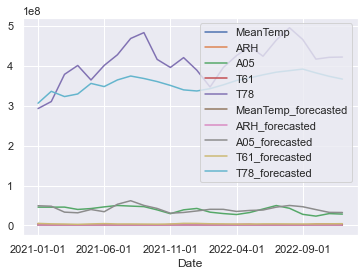

In [34]:
test = features.iloc[-24:,:]
test["MeanTemp_forecasted"] = forecast["MeanTemp_forecasted"]
test["ARH_forecasted"] = forecast["ARH_forecasted"]
test["A05_forecasted"] = forecast["A05_forecasted"]
test["T61_forecasted"] = forecast["T61_forecasted"]
test["T78_forecasted"] = forecast["T78_forecasted"]

test.plot()

## 의약품(3) 다변량 예측

In [9]:
features_considered2 = ['A05', 'T61', 'T78']
features2 = f_data[features_considered2]
features2.index = f_data['Date']
features2

,A05,T61,T78
Date,,,
2010-01-01,56398887,3121279,77640736
2010-02-01,54440020,1188833,75477647
2010-03-01,57782217,1481292,85038128
2010-04-01,55537175,12501228,88930460
2010-05-01,49199325,2459549,101073739
...,...,...,...
2022-08-01,42918408,761678,495302437
2022-09-01,27768210,777352,465947809
2022-10-01,23261359,3207258,416668623


<AxesSubplot:xlabel='Date'>

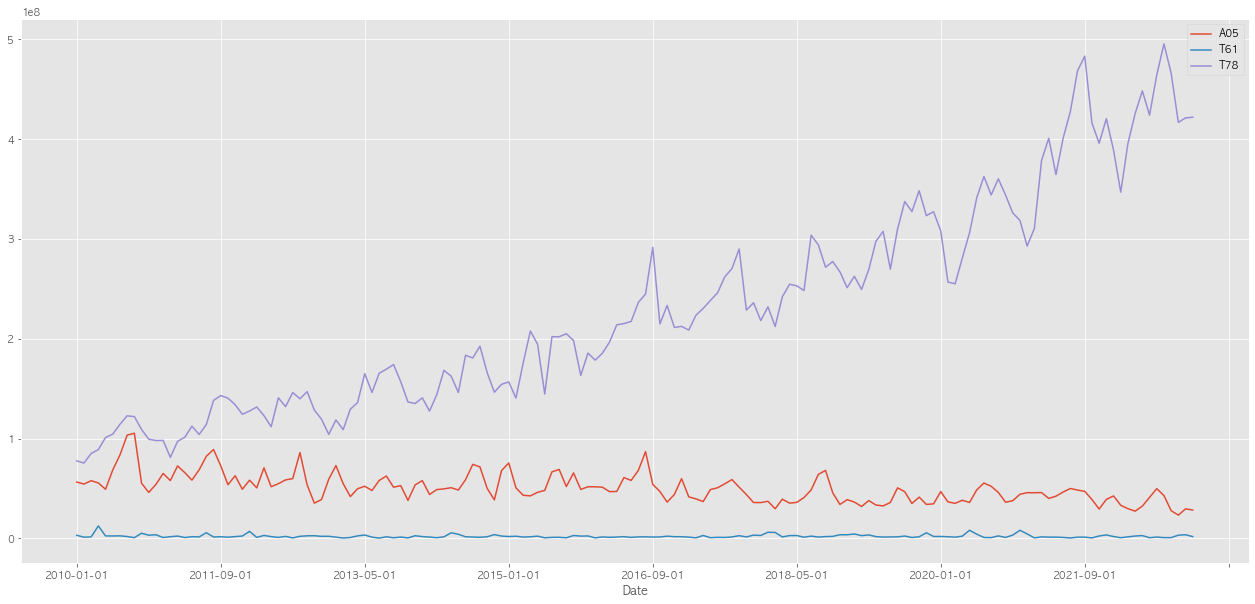

In [10]:
features2.plot(figsize = (22,10))

In [12]:
# 정상성 확인
adfuller_test = adfuller(features2['A05'], autolag= "AIC")
print("=====A05=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features2['T61'], autolag= "AIC")
print("=====T61=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features2['T78'], autolag= "AIC")
print("=====T78=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

=====A05=====
ADF test statistic: -1.2210271861471598
p-value: 0.6644855775909438

=====T61=====
ADF test statistic: -8.540380684800862
p-value: 9.819674181421347e-14

=====T78=====
ADF test statistic: 1.3186572965964811
p-value: 0.9967113833985707


In [13]:
# 1차 차분
features2_diff = features2.diff().dropna()

In [14]:
# 차분한 결과로 다시 정상성 확인
adfuller_test = adfuller(features2['A05'], autolag= "AIC")
print("=====A05=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features2['T61'], autolag= "AIC")
print("=====T61=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
print( )

adfuller_test = adfuller(features2['T78'], autolag= "AIC")
print("=====T78=====")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

=====A05=====
ADF test statistic: -1.2210271861471598
p-value: 0.6644855775909438

=====T61=====
ADF test statistic: -8.540380684800862
p-value: 9.819674181421347e-14

=====T78=====
ADF test statistic: 1.3186572965964811
p-value: 0.9967113833985707


### 모델링

In [15]:
# 마지막 5년(18-22)은 test, 나머지 8년(10-17)은 train
train2 = features2_diff.iloc[:-24,:]
test2 = features2_diff.iloc[-24:,:]

In [16]:
forecasting_model = VAR(train2)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

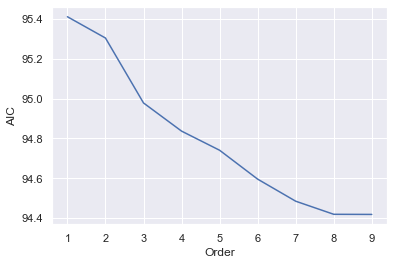

In [17]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [18]:
results2 = forecasting_model.fit(8)
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Aug, 2023
Time:                     18:57:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    96.1335
Nobs:                     123.000    HQIC:                   95.1153
Log likelihood:          -6255.34    FPE:                1.03048e+41
AIC:                      94.4188    Det(Omega_mle):     5.91520e+40
--------------------------------------------------------------------
Results for equation A05
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const   -1385046.528575   1007665.357640           -1.375           0.169
L1.A05        -0.329989         0.097112           -3.398           0.001
L1.T61        -1.070634         0.666081           -1.607           0.108
L1.T78         0

### 예측하기

In [20]:
laaged_values2 = train2.values[-8:]
forecast2 = pd.DataFrame(results2.forecast(y= laaged_values2, steps=24), index = test2.index, columns= ['A05_1d', 'T61_1d', 'T78_1d'])
forecast2

,A05_1d,T61_1d,T78_1d
Date,,,
2021-01-01,5.969195e+06,-3.646359e+06,1.019409e+06
2021-02-01,-6.047653e+06,-9.546631e+05,1.730462e+07
2021-03-01,-1.315887e+07,-7.916513e+05,-8.263436e+06
2021-04-01,1.843122e+06,2.869754e+05,4.312196e+06
2021-05-01,4.348656e+05,9.008444e+05,8.721065e+06
2021-06-01,1.552905e+06,2.255990e+05,1.635509e+06
2021-07-01,1.337291e+07,-5.816445e+05,8.774226e+06
2021-08-01,5.828744e+06,-4.555860e+05,1.115583e+07
2021-09-01,-9.639868e+06,-8.565630e+03,1.159088e+06


In [21]:
forecast2["A05_forecasted"] = features2["A05"].iloc[-24-1] + forecast2['A05_1d'].cumsum()
forecast2["T61_forecasted"] = features2["T61"].iloc[-24-1] + forecast2['T61_1d'].cumsum()
forecast2["T78_forecasted"] = features2["T78"].iloc[-24-1] + forecast2['T78_1d'].cumsum()

forecast2

,A05_1d,T61_1d,T78_1d,A05_forecasted,T61_forecasted,T78_forecasted
Date,,,,,,
2021-01-01,5.969195e+06,-3.646359e+06,1.019409e+06,5.013482e+07,4.458601e+06,3.195643e+08
2021-02-01,-6.047653e+06,-9.546631e+05,1.730462e+07,4.408717e+07,3.503937e+06,3.368689e+08
2021-03-01,-1.315887e+07,-7.916513e+05,-8.263436e+06,3.092830e+07,2.712286e+06,3.286055e+08
2021-04-01,1.843122e+06,2.869754e+05,4.312196e+06,3.277142e+07,2.999262e+06,3.329177e+08
2021-05-01,4.348656e+05,9.008444e+05,8.721065e+06,3.320629e+07,3.900106e+06,3.416387e+08
2021-06-01,1.552905e+06,2.255990e+05,1.635509e+06,3.475920e+07,4.125705e+06,3.432742e+08
2021-07-01,1.337291e+07,-5.816445e+05,8.774226e+06,4.813210e+07,3.544061e+06,3.520485e+08
2021-08-01,5.828744e+06,-4.555860e+05,1.115583e+07,5.396085e+07,3.088474e+06,3.632043e+08
2021-09-01,-9.639868e+06,-8.565630e+03,1.159088e+06,4.432098e+07,3.079909e+06,3.643634e+08


<AxesSubplot:xlabel='Date'>

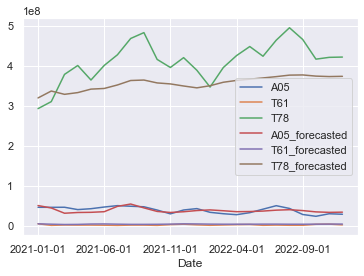

In [26]:
test2 = features2.iloc[-24:,:]

test2["A05_forecasted"] = forecast2["A05_forecasted"]
test2["T61_forecasted"] = forecast2["T61_forecasted"]
test2["T78_forecasted"] = forecast2["T78_forecasted"]

test2.plot()